# **Stochastic MABs**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### The first thing to do is to code a simulator (or environment) to run a Multi-Armed Bandit Trial. For simplicity, we start with the most simple probability distribution, Bernoulli. Thus, rewards will be $r_t \in \{0,1\}$.

In [2]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [3]:
class BernoulliEnvironment(Environment):
    def __init__(self, p, T):
        self.K = len(p)
        self.rewards = np.random.binomial(n=1, p=p, size=(T, self.K))
        self.t = 0

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

In [4]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 100
seed = 17

env = BernoulliEnvironment(p, T)
env.round(0)

1

In [5]:
env.t, env.round(0), env.t

(1, 0, 2)

### How can I interact with this environment? We use Agents

In [6]:
# this is the blueprint of an Agent-type class, we can customize this with our strategy
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

In [7]:
class RandomAgent(Agent):
    def __init__(self, K, T):
        self.actions_sequence = np.random.choice(np.arange(K), size=T)
        self.a_t = None
        self.action_history = np.array([])
        self.t = 0
    def pull_arm(self):
        self.a_t = self.actions_sequence[self.t]
        return self.a_t
    def update(self, r_t):
        self.action_history = np.append(self.action_history, self.a_t)
        self.t += 1

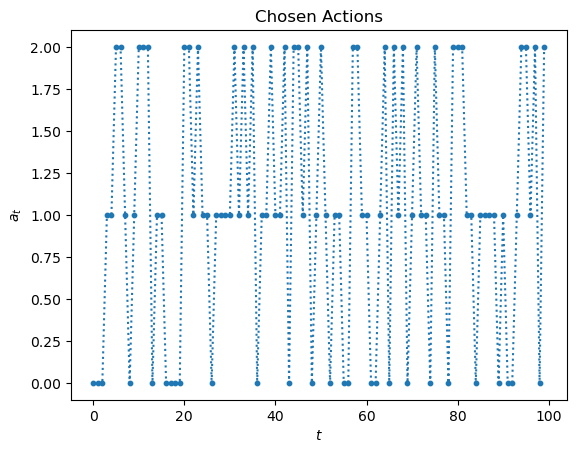

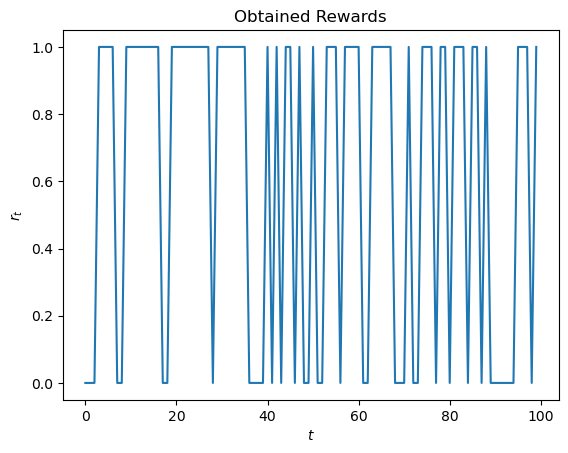

In [8]:
np.random.seed(seed)
env = BernoulliEnvironment(p, T)
rand_agent = RandomAgent(K, T)

rewards = np.array([])
action_sequence = np.array([])
for t in range(T):
    a_t = rand_agent.pull_arm()
    r_t = env.round(a_t)
    rand_agent.update(r_t) # doesn't do anything with r_t
    #logging
    rewards = np.append(rewards, r_t)
    action_sequence = np.append(action_sequence, a_t)

plt.plot(action_sequence, linestyle='dotted')
plt.scatter(np.arange(action_sequence.shape[0]), action_sequence,s=10)
plt.xlabel('$t$')
plt.ylabel('$a_t$')
plt.title('Chosen Actions')
plt.show()

plt.plot(rewards)
plt.xlabel('$t$')
plt.ylabel('$r_t$')
plt.title('Obtained Rewards')
plt.show()

## **The Notion of Regret**

### What is the best action sequence?

In [9]:
best_action = np.argmax(p)
print(f'Best action is {best_action}')

Best action is 2


### The total _expected_ reward of always playing the best action $a^*$ is $T \mu (a^*) = \sum_{t=1}^T \mathbb{E} [r_t(a^*)] = \mathbb{E} [\sum_{t=1}^T r_t(a^*)]$

In [10]:
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

sum(expected_clairvoyant_rewards)

75.0

### However, a clairvoyant doesn't actually gain $T\mu(a^*)$, but $\sum_{t=1}^T r_t(a^*)$, this is the actual clairvoyant's reward (and it's random due to the nature of the environment)

In [11]:
clairvoyant_rewards = env.rewards[:, best_action]

sum(clairvoyant_rewards) 

77

### Pseudo Regret express how bad my actions are, _in expectation_, w.r.t. a clairvoyant, i.e. $R_T = \mathbb{E}[\sum_{t=1}^T r_t(a^*)-r_t(a_t)] = T\mu(a^*) - \sum_{t=1}^T \mathbb{E}[r_t(a_t)] = \sum_{t=1}^T \mathbb{E}[\Delta_{a_t}]$, instead, the actual regret is computed on the rewards observed (including the environment's noise).

In [12]:
expected_agent_rewards = np.repeat(p.sum()/len(p), T)

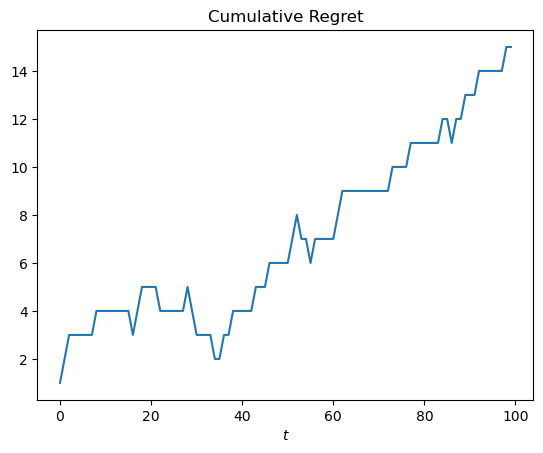

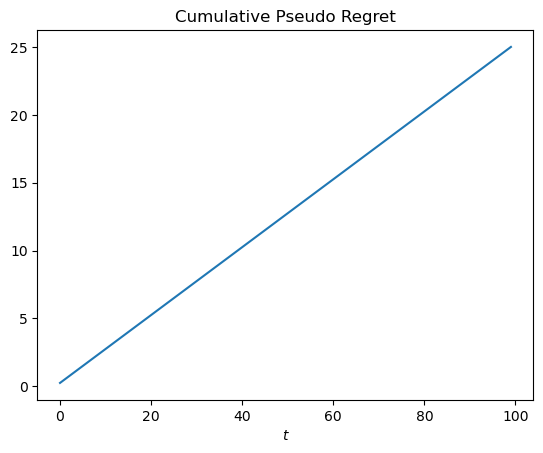

In [13]:
instantaneous_regret = clairvoyant_rewards - rewards
instantaneous_pseudo_regret = expected_clairvoyant_rewards - expected_agent_rewards

cumulative_regret = np.cumsum(instantaneous_regret)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.title('Cumulative Regret')
plt.show()

cumulative_pseudo_regret = np.cumsum(instantaneous_pseudo_regret)
plt.plot(cumulative_pseudo_regret)
plt.xlabel('$t$')
plt.title('Cumulative Pseudo Regret')
plt.show()

### For a random agent is easy to compute the expected cumulative reward, and thus to obtain the cumulative pseudo-regret in a closed form. However, for more complex agents is usually impossible to obtain the true expectation on their rewards.

### In practice, after a bandit trial you usually observe only the first plot. But the more interesting is the second one. 

### So we can proceed by trying the agent on multiple different simulations, and empirically estimate its pseudo-regret as the average of all the regrets attained during the trials.

### We need multiple trials to estimate it:

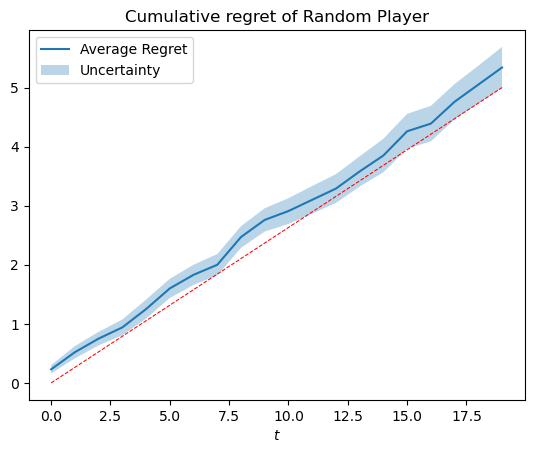

In [18]:
p = np.array([0.25, 0.5, 0.75])
T = 20
expected_clairvoyant_rewards = np.repeat(p[best_action], T) # this remains the same after every trial

#n_trials = 30
n_trials = 50

regret_per_trial = []

np.random.seed(seed)
for _ in range(n_trials):
    env = BernoulliEnvironment(p, T)
    rand_agent = RandomAgent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = rand_agent.pull_arm()
        r_t = env.round(a_t)
        rand_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative regret of Random Player')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot((0,T-1), (0, T*(max(p)-p.sum()/len(p))), 'r', linestyle="--", linewidth=0.75)
plt.xlabel('$t$')
plt.legend()
plt.show()

In [19]:
regret_per_trial.shape

(50, 20)

### We approximated pseudo-regret starting from regrets coming from multiple trials. We also quantified the uncertainty around this estimation.

### **MAIN GOAL IN BANDITS**: Obtain Sub-Linear Regret

### We have to deal with the exploration-exploitation trade-off, but do we really need exploration?

In [20]:
class GreedyAgent(Agent):
    def __init__(self, K, T):
        self.a_t = None
        self.K = K
        self.action_history = np.array([])
        self.n_pulls = np.zeros(K)
        self.empirical_means = np.zeros(K)
        self.t = 0 
    def pull_arm(self):
        if self.t<self.K:
            self.a_t = self.t
        else:
            self.a_t = np.argmax(self.empirical_means)
        return self.a_t
    def update(self, r_t):
        self.action_history = np.append(self.action_history, self.a_t)
        self.n_pulls[self.a_t]+=1
        self.empirical_means[self.a_t] += (r_t - self.empirical_means[self.a_t])/self.n_pulls[self.a_t]
        self.t += 1

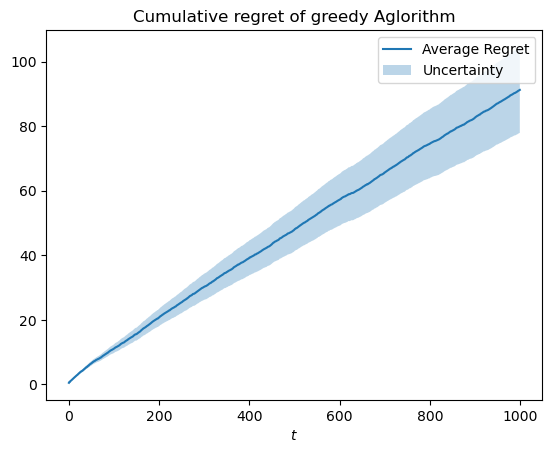

In [21]:
#p = np.array([0.50, 0.25, 0.25, 0.25])
p = np.array([0.25, 0.5, 0.75])
best_action = np.argmax(p)
K = len(p)
T = 1000
seed = 17

env = BernoulliEnvironment(p, T)

expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 150

regret_per_trial = []

np.random.seed(seed)
for _ in range(n_trials):
    env = BernoulliEnvironment(p, T)
    etc_agent = GreedyAgent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = etc_agent.pull_arm()
        r_t = env.round(a_t)
        etc_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title(f'Cumulative regret of greedy Aglorithm')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

In [18]:
## Exercise: implement the instance seen in theory adn show that the greedy algorithm has linear regret on it

## **The Explore-Then-Commit (ETC) Algorithm**

In [23]:
class ETCAgent(Agent):
    def __init__(self, K, T, T0):
        self.K = K 
        self.T = T
        self.T0 = T0
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t <= self.K*self.T0:
            self.a_t = self.t % self.K
        else:
            self.a_t = np.argmax(self.average_rewards)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Will it perform better? Let's estimate the pseudo-regret:

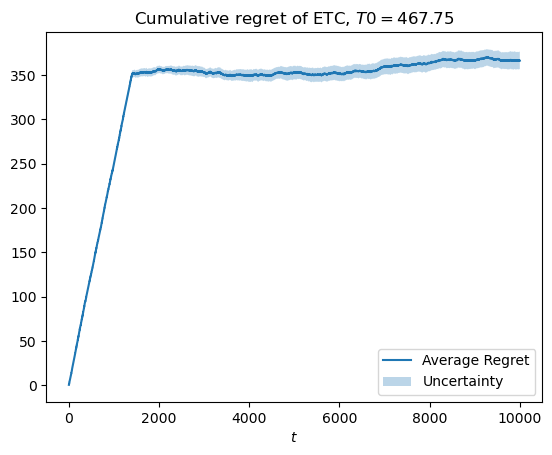

Text(0.5, 1.0, 'number of pulls per arm of ETC')

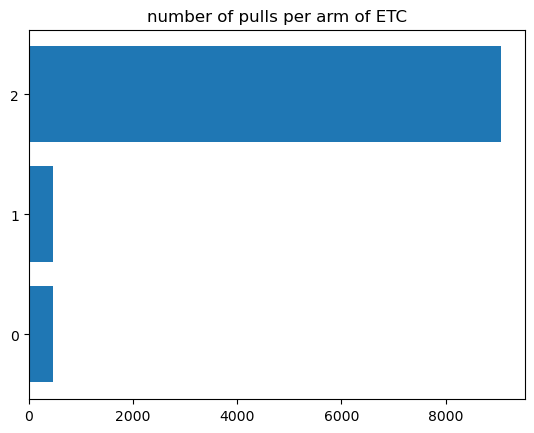

In [24]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
best_action = np.argmax(p)
T = 10000

T0 = (T/K)**(2/3)*np.log(T)**(1/3) # we set the exploration length as prescribed by the theory
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 20

regret_per_trial = []

np.random.seed(seed)
for seed in range(n_trials):
    env = BernoulliEnvironment(p, T)
    etc_agent = ETCAgent(K, T, T0=T0)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = etc_agent.pull_arm()
        r_t = env.round(a_t)
        etc_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title(f'Cumulative regret of ETC, $T0={round(T0,2)}$')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=etc_agent.N_pulls)
plt.title('number of pulls per arm of ETC')

### Can we do even better?

## **The UCB1 Algorithm**

In [26]:
class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Will it perform better? Let's estimate the pseudo-regret:

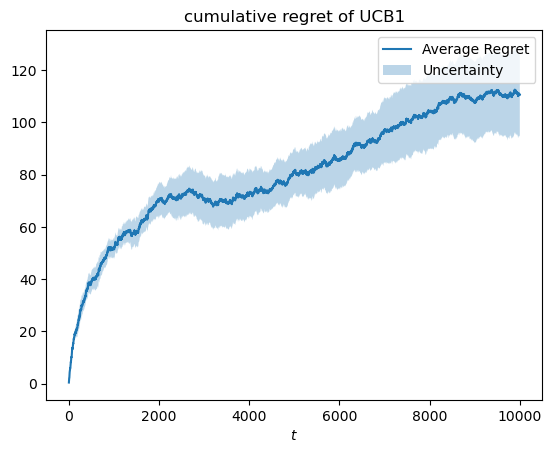

Text(0.5, 1.0, 'number of pulls per arm of UCB1')

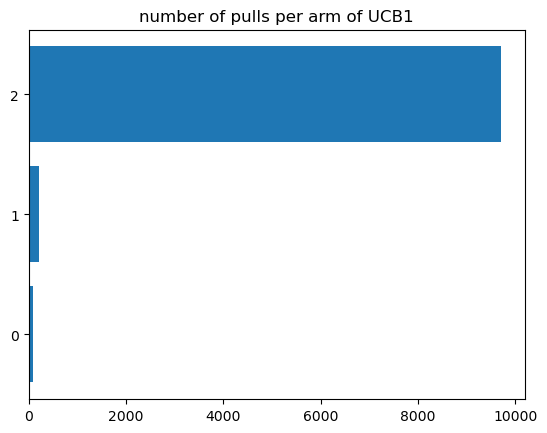

In [27]:
p = np.array([0.25, 0.5, 0.75])
T = 10000
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 10

regret_per_trial = []

np.random.seed(seed)
for seed in range(n_trials):
    env = BernoulliEnvironment(p, T)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of UCB1')

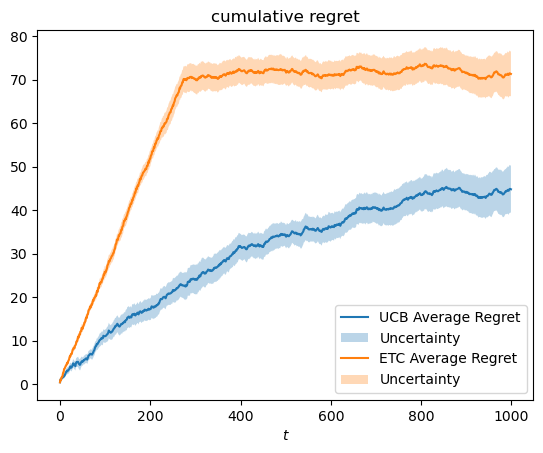

In [33]:
p = np.array([0.25, 0.5, 0.75])
T = 1000
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

T0 = (T/K)**(2/3)*np.log(T)**(1/3) # we set the exploration length as prescribed by the theory

n_trials = 10

ucb_regret_per_trial = []
etc_regret_per_trial = []

np.random.seed(seed)
for seed in range(n_trials):
    state = np.random.get_state()
    env = BernoulliEnvironment(p, T)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    ucb_regret_per_trial.append(cumulative_regret)

    np.random.set_state(state)
    env = BernoulliEnvironment(p, T)
    etc_agent = ETCAgent(K, T, T0)
    agent_rewards = np.array([])
    for t in range(T):
        a_t = etc_agent.pull_arm()
        r_t = env.round(a_t)
        etc_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    etc_regret_per_trial.append(cumulative_regret)


ucb_regret_per_trial = np.array(ucb_regret_per_trial)
etc_regret_per_trial = np.array(etc_regret_per_trial)

ucb_average_regret = ucb_regret_per_trial.mean(axis=0)
ucb_regret_sd = ucb_regret_per_trial.std(axis=0)

etc_average_regret = etc_regret_per_trial.mean(axis=0)
etc_regret_sd = etc_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), ucb_average_regret, label='UCB Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='ETC Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

# plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls)
# plt.title('number of pulls per arm of UCB1')

In [34]:
etc_agent.average_rewards

array([0.20652174, 0.51086957, 0.73406863])

### What happens if the rewards are not in [0,1]?

In [25]:
### Exercise: repeat the previous experiments with an environment generating rewards in [0, 10], and try to make UCB1 work properly
### Hint: Try to use a Binomial instead of a Bernoulli

### Visual representation of confidence intervals shrinking

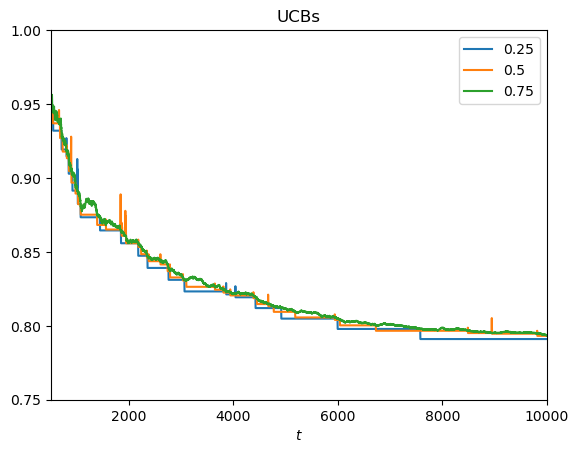

array([  82.,  186., 9732.])

In [35]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
# sigma = 0.1
T = 10000

np.random.seed(seed)
env = BernoulliEnvironment(p, T)
ucb_agent = UCB1Agent(K, T)
n_pulls = np.zeros(K)

ci_widths = np.zeros((T,K))

curr_widths = np.sqrt(2*np.log(T))
curr_average = np.zeros((T,K))

for t in range(T):
    a_t = ucb_agent.pull_arm()
    r_t = env.round(a_t)
    ucb_agent.update(r_t)

    n_pulls[a_t] += 1

    # ci_widths[t,:] = np.sqrt(2*np.log(T)/n_pulls)
    ci_widths[t,:] = np.sqrt(2*np.log(T)/np.maximum(n_pulls,0.1))


    curr_average[t,:] = curr_average[t-1,:]
    curr_average[t,a_t] += (r_t - curr_average[t,a_t])/n_pulls[a_t]

plt.plot(curr_average+ci_widths,label=p)
plt.title('UCBs')
plt.xlabel('$t$')
plt.ylim(0.75,1)
plt.xlim(T/20, T)
# plt.ylim(0.83,0.87)
# plt.xlim(2000,2200)
# plt.ylim(0.82,0.85)
# plt.xlim(3560,3600)
plt.legend()
plt.show()

ucb_agent.N_pulls

In [36]:
ucb_agent.average_rewards

array([0.31707317, 0.47849462, 0.75      ])